In [ ]:
print("🚀 Installing dependencies...")

# Install required packages
!pip install  tensorflow
!pip install  opencv-python
!pip install  mediapipe
!pip install  scikit-learn
!pip install  matplotlib
!pip install  seaborn
!pip install  pandas

🚀 Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
 

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [1]:
# ============================================================================
# CELL 1: Install Dependencies and Setup
# ============================================================================



# Install Kaggle for dataset download
#!pip install -q kaggle

print("✅ All dependencies installed!")

# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import time
import zipfile
from google.colab import files, drive

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

# Check GPU
gpu_info = !nvidia-smi
if len(gpu_info) > 0:
    print("✅ GPU is enabled!")
else:
    print("⚠️  No GPU detected. Training will be slower.")

✅ All dependencies installed!


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ TensorFlow version: 2.19.0
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is enabled!


In [2]:
# ============================================================================
# CELL 2: Mount Google Drive (Optional)
# ============================================================================

# Mount Google Drive to save models and results
from google.colab import drive
drive.mount('/content/drive')

# Create folder for models
!mkdir -p /content/drive/MyDrive/hand_tracking_models

print("✅ Google Drive mounted!")
print("📁 Models will be saved to: /content/drive/MyDrive/hand_tracking_models/")

Mounted at /content/drive
✅ Google Drive mounted!
📁 Models will be saved to: /content/drive/MyDrive/hand_tracking_models/


In [6]:
print("📦 Extracting dataset...")

# Install gdown if not already installed for downloading from Google Drive
!pip install -q gdown

import gdown

# Google Drive file ID for the dataset.zip
# Extracted from: https://drive.google.com/file/d/1s6_pFHzVFj-HWQb5G4InBTQB4lITm4oX/view?usp=sharing
file_id = '1s6_pFHzVFj-HWQb5G4InBTQB4lITm4oX'
output_path = '/tmp/dataset.zip' # Download to a temporary location

print(f"⬇️ Downloading dataset from Google Drive to {output_path}...")
gdown.download(id=file_id, output=output_path, quiet=False)

# Create the destination directory if it doesn't exist
destination_dir = '/content/drive/MyDrive/Colab Notebooks/hand-tracking/dataset'
import os
os.makedirs(destination_dir, exist_ok=True)

# Extract the downloaded zip file
print(f"🔄 Extracting {output_path} to {destination_dir}...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("✅ Dataset extracted!")
print(f"Dataset contents are now in: {destination_dir}")

📦 Extracting dataset...
⬇️ Downloading dataset from Google Drive to /tmp/dataset.zip...


Downloading...
From (original): https://drive.google.com/uc?id=1s6_pFHzVFj-HWQb5G4InBTQB4lITm4oX
From (redirected): https://drive.google.com/uc?id=1s6_pFHzVFj-HWQb5G4InBTQB4lITm4oX&confirm=t&uuid=4175debf-871b-4fde-8e83-77aeffd45c9f
To: /tmp/dataset.zip
100%|██████████| 1.09G/1.09G [00:14<00:00, 77.4MB/s]


🔄 Extracting /tmp/dataset.zip to /content/drive/MyDrive/Colab Notebooks/hand-tracking/dataset...
✅ Dataset extracted!
Dataset contents are now in: /content/drive/MyDrive/Colab Notebooks/hand-tracking/dataset


In [17]:
# ============================================================================
# CELL 6: Model Architecture Classes
# ============================================================================

class GestureRecognitionModel:
    def __init__(self, num_classes, input_shape=(224, 224, 3)):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.model = None

    def build_cnn_model(self):
        """Build custom CNN model"""
        print("\n🏗️  Building Custom CNN Model...")

        model = models.Sequential([
            # Block 1
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),

            # Block 2
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),

            # Block 3
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),

            # Block 4
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),

            # Classifier
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
        )

        self.model = model

        print("\n📊 Model Summary:")
        model.summary()
        print(f"\n✅ Total parameters: {model.count_params():,}")

        return model

    def build_mobilenet_model(self):
        """Build MobileNetV2 transfer learning model"""
        print("\n🏗️  Building MobileNetV2 Transfer Learning Model...")

        base_model = MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )

        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
        )

        self.model = model

        print("\n📊 Model Summary:")
        model.summary()
        print(f"\n✅ Total parameters: {model.count_params():,}")
        print(f"✅ Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

        return model

    def build_resnet50_model(self, sequence_length=30):
        """Build LSTM model for dynamic gesture recognition"""
        # ➕ ADDED: Print model info
        print("\n" + "="*70)
        print("BUILDING ResNet50 MODEL FOR DYNAMIC GESTURES")
        print("="*70)

        model = models.Sequential([
            layers.ResNet50(128, return_sequences=True, input_shape=(sequence_length, 63)),  # 21 landmarks * 3 (x,y,z)
            layers.Dropout(0.3),
            layers.ResNet50(64, return_sequences=True),
            layers.Dropout(0.3),
            layers.ResNet50(32),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model

        # ➕ ADDED: Print model info
        print("\nModel Architecture:")
        model.summary()
        print(f"\nTotal parameters: {model.count_params():,}")
        print("="*70)

        return model



    def plot_history(self, history, model_name='Model'):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Loss
        axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
        axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{model_name}_training_history.png', dpi=150, bbox_inches='tight')
        plt.show()

        # Print final metrics
        print("\n" + "="*70)
        print(f"{model_name} - FINAL TRAINING RESULTS")
        print("="*70)
        print(f"Final Training Accuracy:   {history.history['accuracy'][-1]*100:.2f}%")
        print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
        print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
        print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")
        print("="*70)

print("✅ Model classes defined!")

✅ Model classes defined!


📊 Setting up data generators...
Found 73950 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.

DATASET INFORMATION
Number of classes: 29
Training samples:   73950
Validation samples: 13050
Batch size:         32
Image size:         (224, 224)

Classes: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, del, nothing, space

📸 Sample training images:


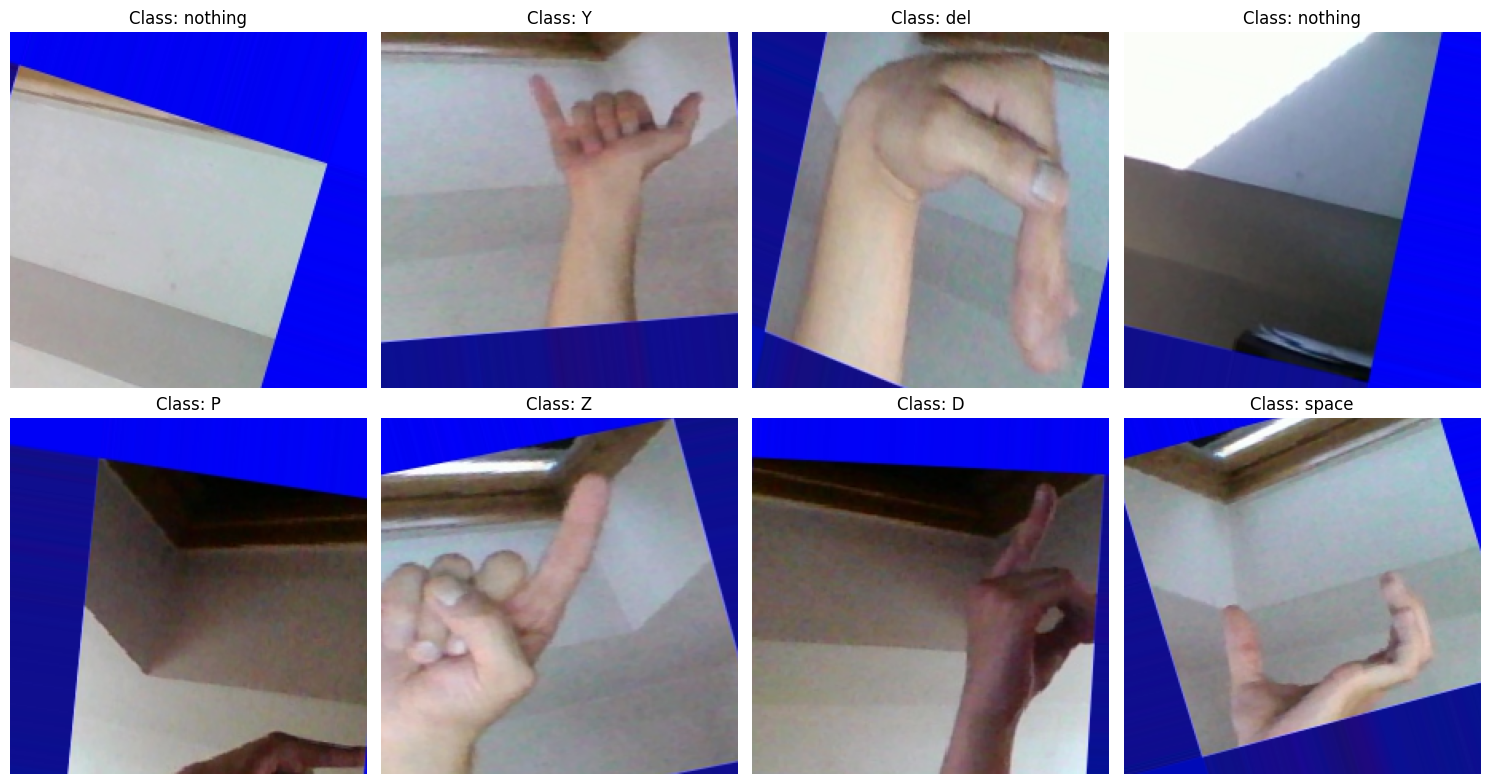

In [10]:
# ============================================================================
# CELL 7: Data Augmentation and Generators
# ============================================================================

print("📊 Setting up data generators...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/hand-tracking/dataset/dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/hand-tracking/dataset/dataset/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class information
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Number of classes: {num_classes}")
print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Batch size:         {BATCH_SIZE}")
print(f"Image size:         {IMG_SIZE}")
print(f"\nClasses: {', '.join(class_names)}")
print("="*70)

# Visualize sample images
def show_sample_images(generator, num_images=8):
    """Show sample images from generator"""
    x, y = next(generator)

    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(x))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(x[i])
        class_idx = np.argmax(y[i])
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n📸 Sample training images:")
show_sample_images(train_generator)


TRAINING CUSTOM CNN MODEL

🏗️  Building Custom CNN Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📊 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,403,997 (74.02 MB)

 Trainable params: 19,403,037 (74.02 MB)

 Non-trainable params: 960 (3.75 KB)


✅ Total parameters: 19,403,997

🚀 Starting training for 30 epochs...
⏳ This may take 30-60 minutes with GPU



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.0359 - loss: 4.0183 - top_k_categorical_accuracy: 0.1058
Epoch 1: val_accuracy improved from -inf to 0.03425, saving model to best_cnn_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 1034s 442ms/step - accuracy: 0.0359 - loss: 4.0181 - top_k_categorical_accuracy: 0.1058 - val_accuracy: 0.0343 - val_loss: 3.3685 - val_top_k_categorical_accuracy: 0.1125 - learning_rate: 0.0010
Epoch 2/30
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0334 - loss: 3.3711 - top_k_categorical_accuracy: 0.1019
Epoch 2: val_accuracy improved from 0.03425 to 0.03448, saving model to best_cnn_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 989s 428ms/step - accuracy: 0.0334 - loss: 3.3711 - top_k_categorical_accuracy: 0.1019 - val_accuracy: 0.0345 - val_loss: 3.3674 - val_top_k_categorical_accuracy: 0.1034 - learning_rate: 0.0010
Epoch 3/30
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.0335 - loss: 3.3675 - top_k_categorical_accuracy: 0.0994
Epoch 3: val_accuracy did not improve from 0.03448
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 995s 430ms/step - accuracy: 0.0335 - loss: 3.3675 - top_k_categorical_accuracy: 0.0994 - val_accuracy: 0.0345 - val_loss: 3.3674 - val_top_k_categorical_accuracy: 0.1034 - learning_rate: 0.0010
Epoch 4/30
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.0340 - loss: 3.3735 - top_k_categorical_accuracy: 0.1013
Epoch 4: val_accuracy did not improve from 0.03448
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 975s 422ms/step - accuracy: 0.0340 - loss: 3.3735 - top_k_categorical_accuracy: 0.1013 - val_accuracy: 0.0345 - val_loss: 3.3674 - val_top_k_categorical_accuracy: 

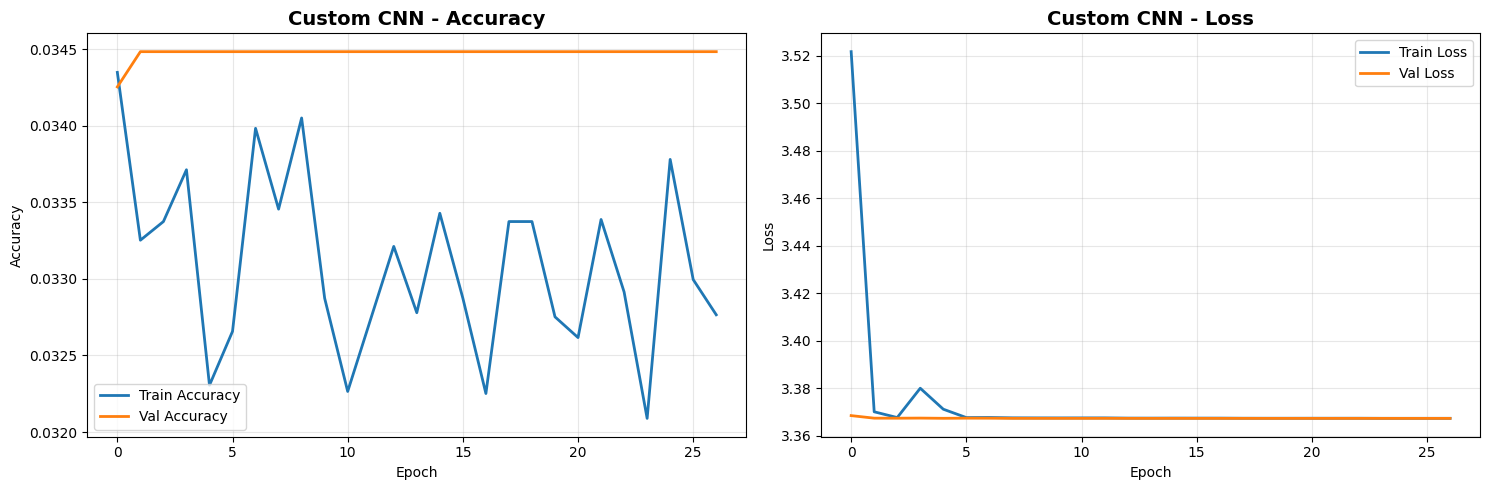


Custom CNN - FINAL TRAINING RESULTS
Final Training Accuracy:   3.28%
Final Validation Accuracy: 3.45%
Final Training Loss:       3.3673
Final Validation Loss:     3.3673

💾 Model saved as: final_cnn_model.h5
✅ Models backed up to Google Drive!


In [9]:
# ============================================================================
# CELL 8: Train Custom CNN Model
# ============================================================================

print("\n" + "="*70)
print("TRAINING CUSTOM CNN MODEL")
print("="*70)

# Initialize model
cnn_model = GestureRecognitionModel(num_classes=num_classes)
cnn_model.build_cnn_model()

# Set training parameters
EPOCHS = 30  # Adjust as needed (start with 30, can increase to 50)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print(f"\n🚀 Starting training for {EPOCHS} epochs...")
print("⏳ This may take 30-60 minutes with GPU\n")

start_time = time.time()

history_cnn = cnn_model.model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes!")

# Plot training history
cnn_model.plot_history(history_cnn, 'Custom CNN')

# Save final model
cnn_model.model.save('final_cnn_model.h5')
print("\n💾 Model saved as: final_cnn_model.h5")

# Copy to Google Drive
!cp final_cnn_model.h5 /content/drive/MyDrive/hand_tracking_models/
!cp best_cnn_model.h5 /content/drive/MyDrive/hand_tracking_models/
print("✅ Models backed up to Google Drive!")


TRAINING MOBILENETV2 TRANSFER LEARNING MODEL

🏗️  Building MobileNetV2 Transfer Learning Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

📊 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,052,637 (11.64 MB)

 Trainable params: 794,653 (3.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


✅ Total parameters: 3,052,637
✅ Trainable parameters: 794,653

🚀 Starting training for 5 epochs...
⏳ Transfer learning is faster - typically 20-40 minutes

Epoch 1/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4999 - loss: 1.6736 - top_k_categorical_accuracy: 0.7101
Epoch 1: val_accuracy improved from -inf to 0.90383, saving model to best_mobilenet_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 1066s 450ms/step - accuracy: 0.4999 - loss: 1.6734 - top_k_categorical_accuracy: 0.7101 - val_accuracy: 0.9038 - val_loss: 0.2837 - val_top_k_categorical_accuracy: 0.9870 - learning_rate: 0.0010
Epoch 2/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7686 - loss: 0.7278 - top_k_categorical_accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.90383 to 0.94107, saving model to best_mobilenet_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 979s 424ms/step - accuracy: 0.7686 - loss: 0.7277 - top_k_categorical_accuracy: 0.9252 - val_accuracy: 0.9411 - val_loss: 0.1865 - val_top_k_categorical_accuracy: 0.9919 - learning_rate: 0.0010
Epoch 3/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7972 - loss: 0.6338 - top_k_categorical_accuracy: 0.9372
Epoch 3: val_accuracy improved from 0.94107 to 0.95341, saving model to best_mobilenet_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 985s 426ms/step - accuracy: 0.7972 - loss: 0.6338 - top_k_categorical_accuracy: 0.9373 - val_accuracy: 0.9534 - val_loss: 0.1489 - val_top_k_categorical_accuracy: 0.9942 - learning_rate: 0.0010
Epoch 4/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8218 - loss: 0.5647 - top_k_categorical_accuracy: 0.9467
Epoch 4: val_accuracy improved from 0.95341 to 0.95425, saving model to best_mobilenet_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 984s 426ms/step - accuracy: 0.8218 - loss: 0.5647 - top_k_categorical_accuracy: 0.9467 - val_accuracy: 0.9543 - val_loss: 0.1440 - val_top_k_categorical_accuracy: 0.9936 - learning_rate: 0.0010
Epoch 5/5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8303 - loss: 0.5386 - top_k_categorical_accuracy: 0.9514
Epoch 5: val_accuracy improved from 0.95425 to 0.95770, saving model to best_mobilenet_model.h5


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 971s 420ms/step - accuracy: 0.8303 - loss: 0.5386 - top_k_categorical_accuracy: 0.9514 - val_accuracy: 0.9577 - val_loss: 0.1378 - val_top_k_categorical_accuracy: 0.9923 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

✅ Training completed in 83.10 minutes!


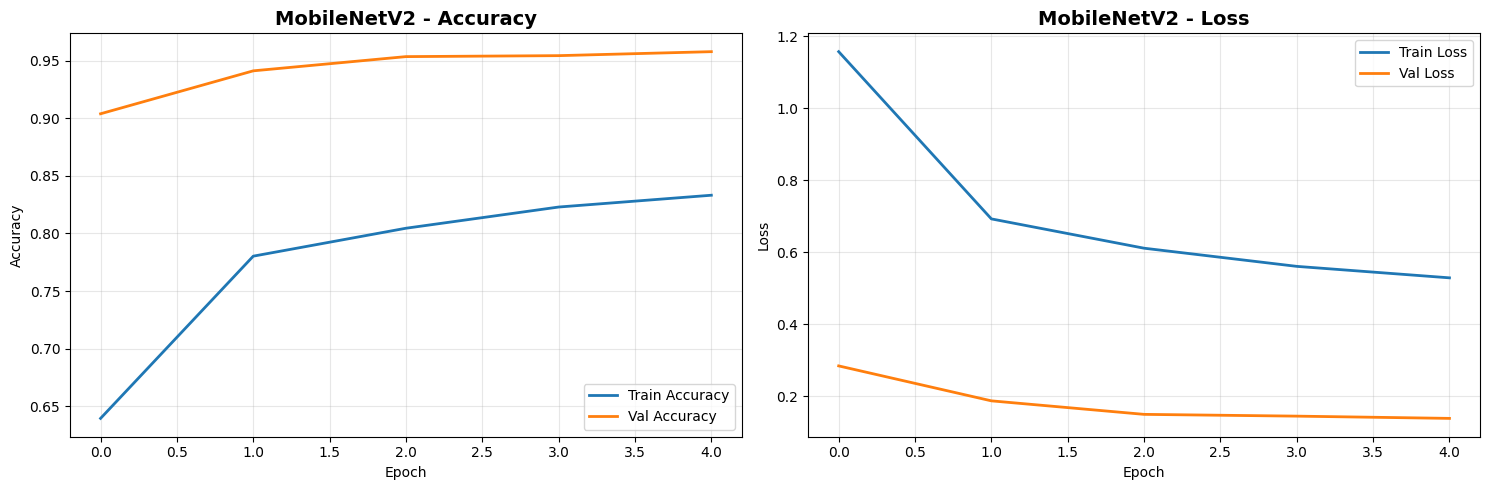


MobileNetV2 - FINAL TRAINING RESULTS
Final Training Accuracy:   83.32%
Final Validation Accuracy: 95.77%
Final Training Loss:       0.5286
Final Validation Loss:     0.1378

💾 Model saved as: final_mobilenet_model.h5
✅ Models backed up to Google Drive!


In [11]:
# ============================================================================
# CELL 9: Train MobileNetV2 Transfer Learning Model
# ============================================================================

print("\n" + "="*70)
print("TRAINING MOBILENETV2 TRANSFER LEARNING MODEL")
print("="*70)

# Set training parameters
EPOCHS = 5  # Adjust as needed (start with 5, can increase to 50)

# Initialize model
mobilenet_model = GestureRecognitionModel(num_classes=num_classes)
mobilenet_model.build_mobilenet_model()

# Callbacks
callbacks_mobilenet = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_mobilenet_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print(f"\n🚀 Starting training for {EPOCHS} epochs...")
print("⏳ Transfer learning is faster - typically 20-40 minutes\n")

start_time = time.time()

history_mobilenet = mobilenet_model.model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_mobilenet,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes!")

# Plot training history
mobilenet_model.plot_history(history_mobilenet, 'MobileNetV2')

# Save final model
mobilenet_model.model.save('final_mobilenet_model.h5')
print("\n💾 Model saved as: final_mobilenet_model.h5")

# Copy to Google Drive
!cp final_mobilenet_model.h5 /content/drive/MyDrive/hand_tracking_models/
!cp best_mobilenet_model.h5 /content/drive/MyDrive/hand_tracking_models/
print("✅ Models backed up to Google Drive!")

In [12]:
#saved keras model for MobileNet
# Save final model
mobilenet_model.model.save('final_mobilenet_model.keras')
print("\n💾 Model saved as: final_mobilenet_model.kearas")

# Copy to Google Drive
!cp final_mobilenet_model.keras /content/drive/MyDrive/hand_tracking_models/
!cp best_mobilenet_model.keras /content/drive/MyDrive/hand_tracking_models/


💾 Model saved as: final_mobilenet_model.kearas
cp: cannot stat 'best_mobilenet_model.keras': No such file or directory


In [19]:
# ============================================================================
# CELL 9: Train ResNet50 Learning Model
# ============================================================================
print("\n" + "="*70)
print("TRAINING ResNet50 LEARNING MODEL")
print("="*70)

# Set training parameters
EPOCHS = 5  # Adjust as needed (start with 5, can increase to 50)

# Initialize model
resnet50_model = GestureRecognitionModel(num_classes=num_classes)
resnet50_model.build_resnet50_model()

# Callbacks
callbacks_mobilenet = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_resnet50_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_resnet50_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print(f"\n🚀 Starting training for {EPOCHS} epochs...")
print("⏳ Transfer learning is faster - typically 20-40 minutes\n")

start_time = time.time()

history_mobilenet = resnet50_model.model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_mobilenet,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes!")

# Plot training history
resnet50_model.plot_history(history_mobilenet, 'LSTM')

# Save final model
resnet50_model.model.save('final_resnet50_model.h5')
resnet50_model.model.save('final_resnet50_model.keras')
print("\n💾 Model saved as: final_resnet50_model.h5")
print("\n💾 Model saved as: final_resnet50_model.keras")

# Copy to Google Drive
!cp final_resnet50_model.h5 /content/drive/MyDrive/hand_tracking_models/
!cp best_resnet50_model.h5 /content/drive/MyDrive/hand_tracking_models/

!cp final_resnet50_model.keras /content/drive/MyDrive/hand_tracking_models/
!cp best_resnet50_model.keras /content/drive/MyDrive/hand_tracking_models/
print("✅ Models backed up to Google Drive!")


TRAINING ResNet50 LEARNING MODEL

BUILDING ResNet50 MODEL FOR DYNAMIC GESTURES


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'ResNet50'

In [20]:
# ============================================================================
# CELL 10: Model Evaluation and Comparison
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate CNN Model
print("\n1️⃣ Evaluating Custom CNN Model...")
cnn_results = cnn_model.model.evaluate(val_generator, verbose=1)
print(f"\n   CNN Accuracy: {cnn_results[1]*100:.2f}%")
print(f"   CNN Top-3 Accuracy: {cnn_results[2]*100:.2f}%")

# Evaluate MobileNetV2 Model
print("\n2️⃣ Evaluating MobileNetV2 Model...")
mobilenet_results = mobilenet_model.model.evaluate(val_generator, verbose=1)
print(f"\n   MobileNetV2 Accuracy: {mobilenet_results[1]*100:.2f}%")
print(f"   MobileNetV2 Top-3 Accuracy: {mobilenet_results[2]*100:.2f}%")


"""

# Evaluate LSTM Model
print("\n2️⃣ Evaluating LSTM Model...")
lstm_results = lstm_model.model.evaluate(val_generator, verbose=1)
print(f"\n   LSTM Accuracy: {lstm_results[1]*100:.2f}%")
print(f"   MobileNetV2 Top-3 Accuracy: {lstm_results[2]*100:.2f}%")
"""


# Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<15} {'Top-3 Accuracy':<15}")
print("-" * 70)
print(f"{'Custom CNN':<20} {cnn_results[1]*100:>13.2f}%  {cnn_results[2]*100:>13.2f}%")
print(f"{'MobileNetV2':<20} {mobilenet_results[1]*100:>13.2f}%  {mobilenet_results[2]*100:>13.2f}%")
#print(f"{'lSTM':<20} {lstm_results[1]*100:>13.2f}%  {lstm_results[2]*100:>13.2f}%")
print("="*70)

# Determine best model
if cnn_results[1] > mobilenet_results[1]:
    print("\n🏆 Best Model: Custom CNN")
    best_model = cnn_model.model
    best_model_name = 'CNN'
#elif mobilenet_results[1] > lstm_results[1]:
    #print("\n🏆 Best Model: MobileNetV2")
    #best_model = mobilenet_model.model
    #best_model_name = 'MobileNetV2'
else:
    print("\n🏆 Best Model: MobileNetV2")
    best_model = mobilenet_model.model
    best_model_name = 'MobileNetV2'


MODEL EVALUATION

1️⃣ Evaluating Custom CNN Model...
408/408 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.0217 - loss: 3.3671 - top_k_categorical_accuracy: 0.0568

   CNN Accuracy: 3.45%
   CNN Top-3 Accuracy: 10.34%

2️⃣ Evaluating MobileNetV2 Model...
408/408 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.9642 - loss: 0.1216 - top_k_categorical_accuracy: 0.9934

   MobileNetV2 Accuracy: 95.77%
   MobileNetV2 Top-3 Accuracy: 99.23%

MODEL COMPARISON
Model                Accuracy        Top-3 Accuracy 
----------------------------------------------------------------------
Custom CNN                    3.45%          10.34%
MobileNetV2                  95.77%          99.23%

🏆 Best Model: MobileNetV2



📊 Generating confusion matrix for best model...
408/408 ━━━━━━━━━━━━━━━━━━━━ 49s 106ms/step


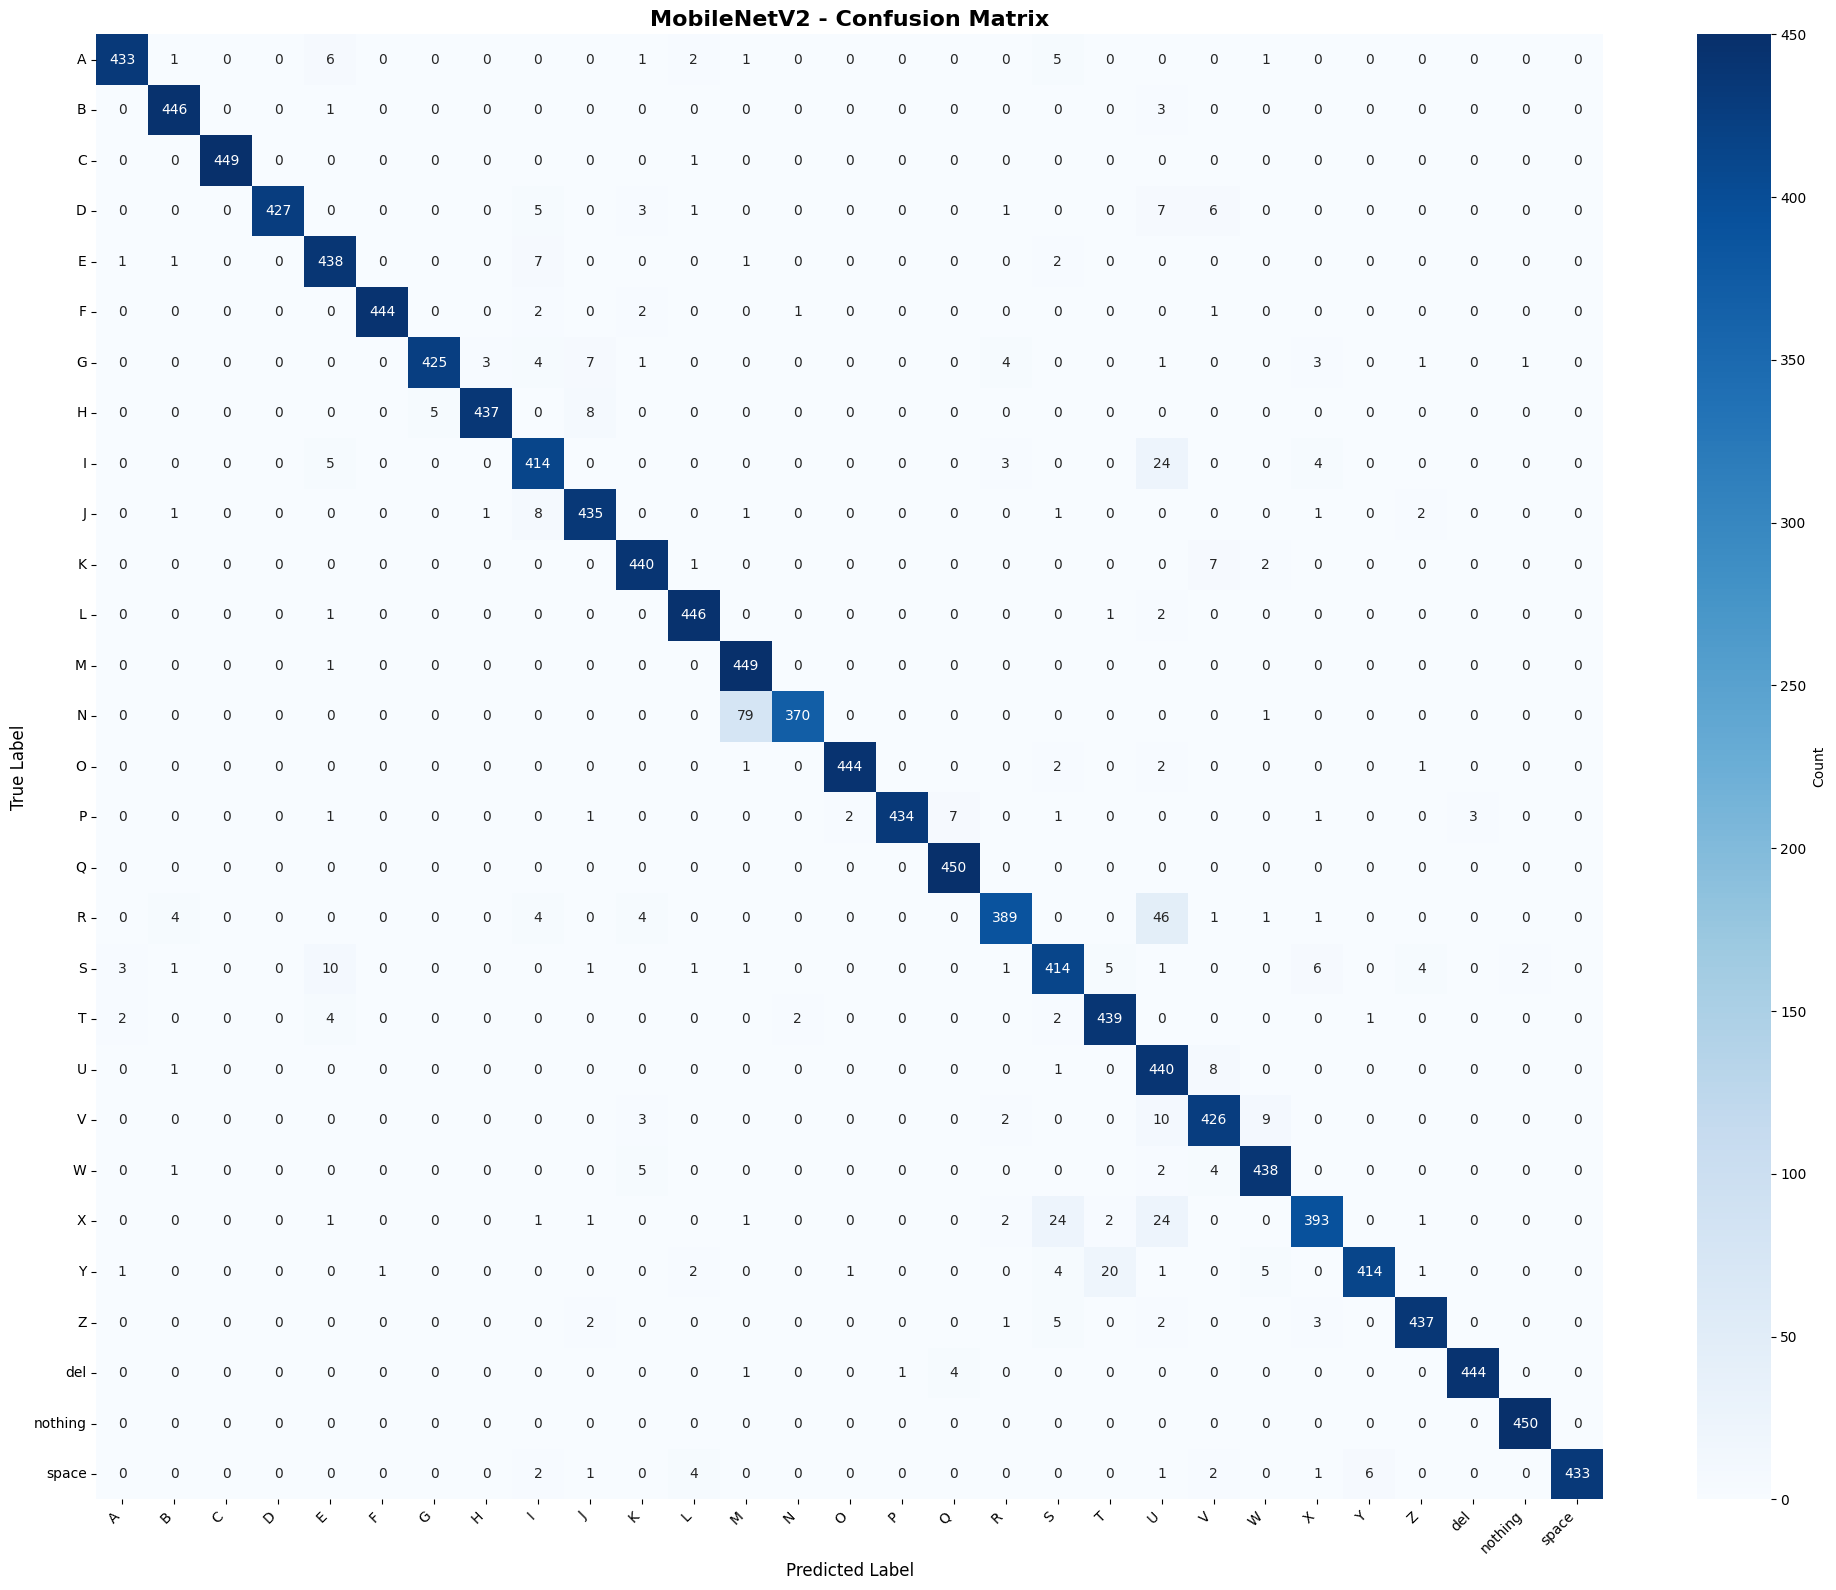


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A       0.98      0.96      0.97       450
           B       0.98      0.99      0.98       450
           C       1.00      1.00      1.00       450
           D       1.00      0.95      0.97       450
           E       0.94      0.97      0.95       450
           F       1.00      0.99      0.99       450
           G       0.99      0.94      0.97       450
           H       0.99      0.97      0.98       450
           I       0.93      0.92      0.92       450
           J       0.95      0.97      0.96       450
           K       0.96      0.98      0.97       450
           L       0.97      0.99      0.98       450
           M       0.84      1.00      0.91       450
           N       0.99      0.82      0.90       450
           O       0.99      0.99      0.99       450
           P       1.00      0.96      0.98       450
           Q       0.98      1.00      0.99       450
    

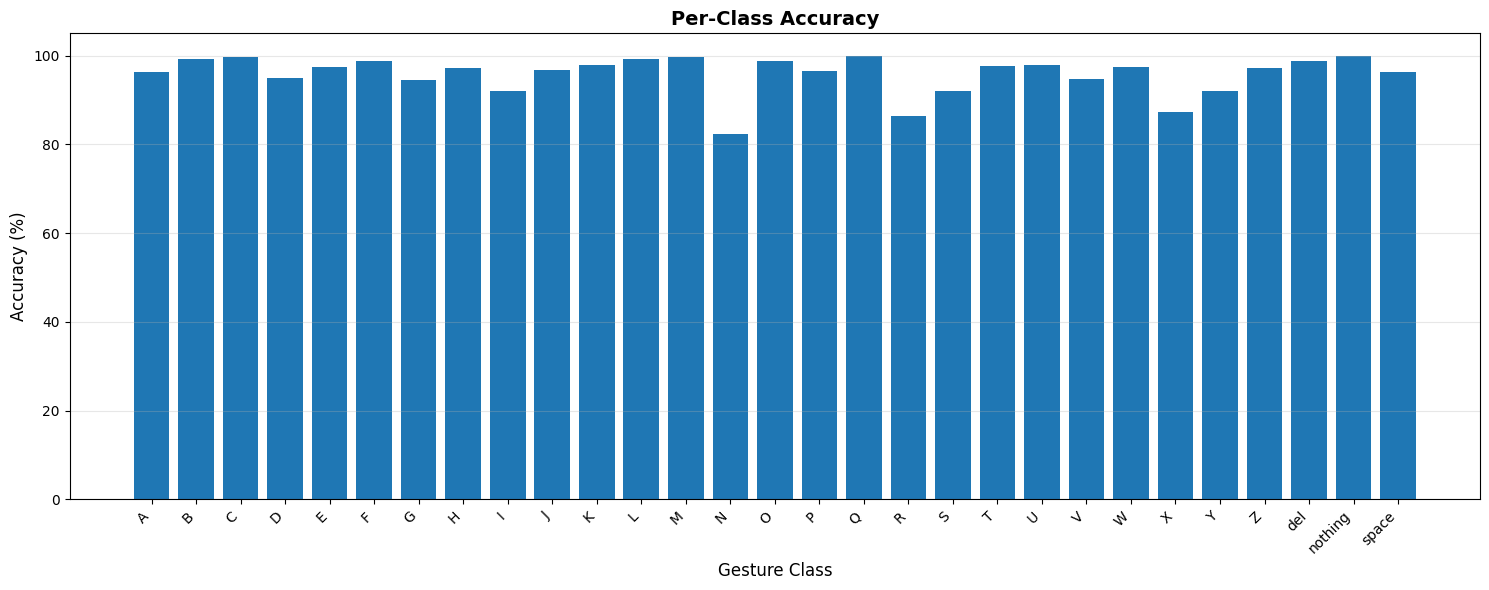


✅ Overall Accuracy: 95.77%


In [21]:
# ============================================================================
# CELL 11: Detailed Evaluation - Confusion Matrix
# ============================================================================

print("\n📊 Generating confusion matrix for best model...")

# Generate predictions
val_generator.reset()
y_pred = best_model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(15, 6))
plt.bar(class_names, class_accuracy * 100)
plt.xlabel('Gesture Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Overall Accuracy: {np.mean(y_pred_classes == y_true)*100:.2f}%")

In [22]:
# ============================================================================
# CELL 12: Download Trained Models
# ============================================================================

print("\n📥 Preparing models for download...")

# Create a zip file with all models
!zip -q models_package.zip *.h5 *.png

print("✅ Models packaged!")
print("\n📦 Package contents:")
!unzip -l models_package.zip

# Download the package
print("\n⬇️  Downloading models package...")
files.download('models_package.zip')

print("\n✅ Download started!")
print("\n📋 Package includes:")
print("   - final_cnn_model.h5")
print("   - best_cnn_model.h5")
print("   - final_mobilenet_model.h5")
print("   - best_mobilenet_model.h5")
print("   - Training history plots")
print("   - Confusion matrix")
print("   - Per-class accuracy chart")

print("\n💡 To use in your project:")
print("   1. Extract models_package.zip")
print("   2. Copy best_cnn_model.h5 to backend/models/gesture_model.h5")
print("   3. Run: python app.py")# ============================================================================
# CELL 12: Download Trained Models
# ============================================================================

print("\n📥 Preparing models for download...")

# Create a zip file with all models
!zip -q models_package.zip *.h5 *.png

print("✅ Models packaged!")
print("\n📦 Package contents:")
!unzip -l models_package.zip

# Download the package
print("\n⬇️  Downloading models package...")
files.download('models_package.zip')

print("\n✅ Download started!")
print("\n📋 Package includes:")
print("   - final_cnn_model.h5")
print("   - best_cnn_model.h5")
print("   - final_mobilenet_model.h5")
print("   - best_mobilenet_model.h5")
print("   - Training history plots")
print("   - Confusion matrix")
print("   - Per-class accuracy chart")

print("\n💡 To use in your project:")
print("   1. Extract models_package.zip")
print("   2. Copy best_cnn_model.h5 to backend/models/gesture_model.h5")
print("   3. Run: python app.py")


📥 Preparing models for download...
✅ Models packaged!

📦 Package contents:
Archive:  models_package.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
232938488  2025-11-19 23:46   best_cnn_model.h5
 18947040  2025-11-20 08:02   best_mobilenet_model.h5
232938488  2025-11-20 06:38   final_cnn_model.h5
 18947040  2025-11-20 08:02   final_mobilenet_model.h5
   208372  2025-11-20 08:32   confusion_matrix.png
   120780  2025-11-20 06:38   Custom CNN_training_history.png
    87066  2025-11-20 08:02   MobileNetV2_training_history.png
    51781  2025-11-20 08:32   per_class_accuracy.png
  1662275  2025-11-20 06:38   sample_images.png
---------                     -------
505901330                     9 files

⬇️  Downloading models package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started!

📋 Package includes:
   - final_cnn_model.h5
   - best_cnn_model.h5
   - final_mobilenet_model.h5
   - best_mobilenet_model.h5
   - Training history plots
   - Confusion matrix
   - Per-class accuracy chart

💡 To use in your project:
   1. Extract models_package.zip
   2. Copy best_cnn_model.h5 to backend/models/gesture_model.h5
   3. Run: python app.py

📥 Preparing models for download...
✅ Models packaged!

📦 Package contents:
Archive:  models_package.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
232938488  2025-11-19 23:46   best_cnn_model.h5
 18947040  2025-11-20 08:02   best_mobilenet_model.h5
232938488  2025-11-20 06:38   final_cnn_model.h5
 18947040  2025-11-20 08:02   final_mobilenet_model.h5
   208372  2025-11-20 08:32   confusion_matrix.png
   120780  2025-11-20 06:38   Custom CNN_training_history.png
    87066  2025-11-20 08:02   MobileNetV2_training_history.png
    51781  2025-11-20 08:32   per_class_accuracy.png
  1662275  20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started!

📋 Package includes:
   - final_cnn_model.h5
   - best_cnn_model.h5
   - final_mobilenet_model.h5
   - best_mobilenet_model.h5
   - Training history plots
   - Confusion matrix
   - Per-class accuracy chart

💡 To use in your project:
   1. Extract models_package.zip
   2. Copy best_cnn_model.h5 to backend/models/gesture_model.h5
   3. Run: python app.py



🧪 Testing model with sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


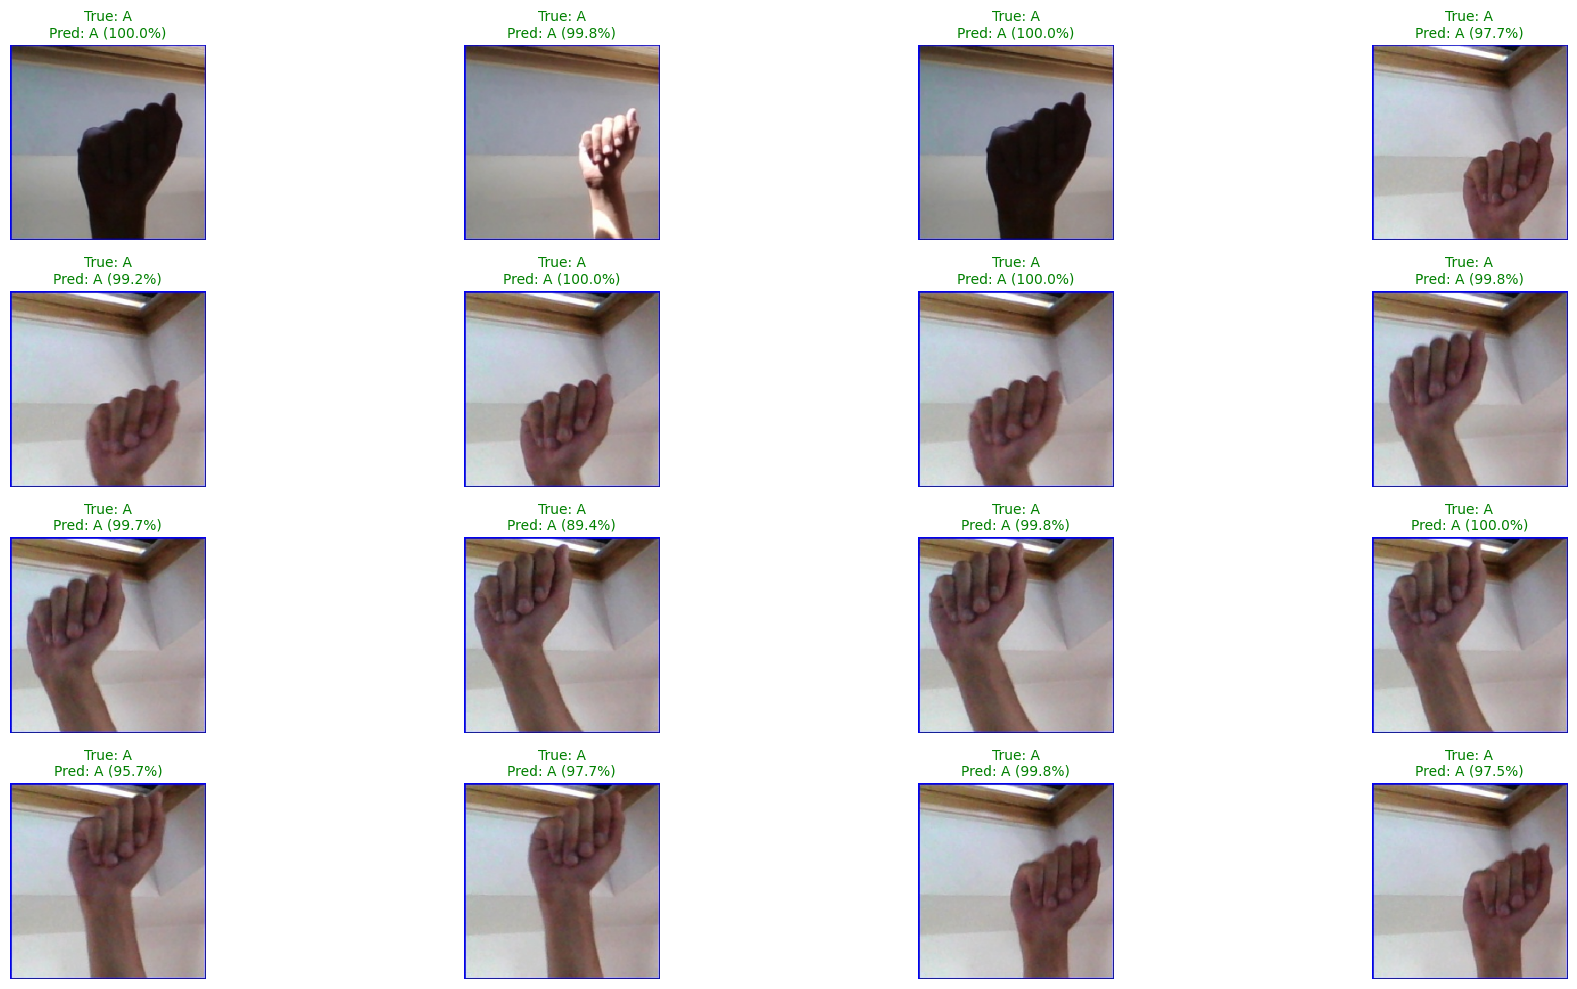


✅ Sample predictions complete!


In [23]:
# ============================================================================
# CELL 13: Test Model with Sample Predictions
# ============================================================================

print("\n🧪 Testing model with sample predictions...")

# Get a batch of images
val_generator.reset()
x_test, y_test = next(val_generator)

# Make predictions
predictions = best_model.predict(x_test)

# Show results
plt.figure(figsize=(20, 10))
for i in range(min(16, len(x_test))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i])

    true_idx = np.argmax(y_test[i])
    pred_idx = np.argmax(predictions[i])
    confidence = predictions[i][pred_idx] * 100

    true_label = class_names[true_idx]
    pred_label = class_names[pred_idx]

    color = 'green' if true_idx == pred_idx else 'red'

    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
             color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Sample predictions complete!")